In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import math
import time
import os
import random
import scipy.io as sio
import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import dill as pickle
# fastai
# from fastai import *
# from fastai.vision import *
# from fastai.callbacks import *

from PIL import Image

In [3]:
# use the parent's path
import sys
sys.path.append("../")

In [4]:
from config import config_cls

In [5]:
config = config_cls[os.getenv('ENV', 'default')]

In [6]:
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

# Tile width / height in pixels
TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512

In [7]:
tile_x, tile_y = 7680, 10240

In [9]:
datas = json.load(open(config.DATA_ROOT / 'external' / 'debug_output.json'))

In [26]:
line_res = {}
for item0 in datas:
    ts = item0['timestamp']
    for item1 in item0['heatmap']:
        x, y, val = item1
        if f'{x}_{y}' in line_res:
            pass
        else:
            line_res[f'{x}_{y}'] = {}
        if "x_value" not in line_res[f'{x}_{y}']: 
            line_res[f'{x}_{y}']["x_value"] = []
        if "y_value" not in line_res[f'{x}_{y}']: 
            line_res[f'{x}_{y}']["y_value"] = []
        line_res[f'{x}_{y}']["x_value"].append(ts)
        line_res[f'{x}_{y}']["y_value"].append(val)

In [29]:
item1

[63, 63, -1]

# 1. 数据读取
1.1 tiles 文件meta data读取  
1.2 metadata 读取  

一张原始卫星图像被切割为若干tiles图像，每张图像默认512x512 pixel, 示例中tile_x， tile_y 定义为当前tile 在原图当中的像素级别坐标  
需要准备工具映射经纬度到像素级别坐标中（队友support）

In [8]:
datadir = config.DATA_ROOT /'raw'/ f'sentinel-2a-tile-{tile_x}x-{tile_y}y'

In [9]:
# files = [file_name for file_name in (datadir / 'timeseries').glob(f'{tile_x}-{tile_y}-*.png')]
files = [file_name for file_name in (datadir / 'eda_data').glob(f'{tile_x}-{tile_y}-*.png')]
sensing_band_types = [file_name.name.split('-')[2] for file_name in files]
date_str = [
    file_name.name[len(f'{tile_x}-{tile_y}-{band}-'): -1 * len('.png')]
    for file_name, band in zip(files, sensing_band_types)]
file_info = pd.DataFrame({'IMG_FILE': files, 'SENSING_BAND': sensing_band_types, 'DATE_DT': date_str}).sort_values(['SENSING_BAND', 'DATE_DT'])
# The assumption that is all sensing band image have save date range
assert file_info.SENSING_BAND.value_counts().max() == file_info.SENSING_BAND.value_counts().min()

In [18]:
datadir / 'eda_data'

PosixPath('/Users/kevindu/Documents/workspace/ai/geo/mel-datathon-data/data/raw/sentinel-2a-tile-7680x-10240y/eda_data')

In [10]:
from pandas.io.json import json_normalize

metadata_files = [file for file in (datadir / 'metadata').glob(f'*.json')]
meta_dates = [file.name.split('.')[0] for file in metadata_files]
metadata = (
    json_normalize(
        [json.load(open(file, 'r')) for file in metadata_files]
        , max_level=1)
    .assign(DATE_DT=pd.to_datetime(meta_dates))
    .set_index('DATE_DT')
    .sort_index()
)

In [57]:
from functools import reduce

In [63]:

def plot(file_name, val_thred=230, ratio_thred=0.3):
    _, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
    cloud_img1 = np.array(Image.open(file_name))
    axs[0].hist(cloud_img1.flatten(), bins=100);
    axs[1].imshow(Image.open(file_name));
    total_px = reduce(lambda x, y: x*y, cloud_img1.shape, 1)
    w_ratio = (cloud_img1 > val_thred).sum() / total_px
    print(w_ratio)

In [43]:
EDA_DATA_ROOT = Path('/Users/kevindu/Documents/workspace/ai/geo/mel-datathon-data/data/raw/sentinel-2a-tile-7680x-10240y')

0.989892323811849


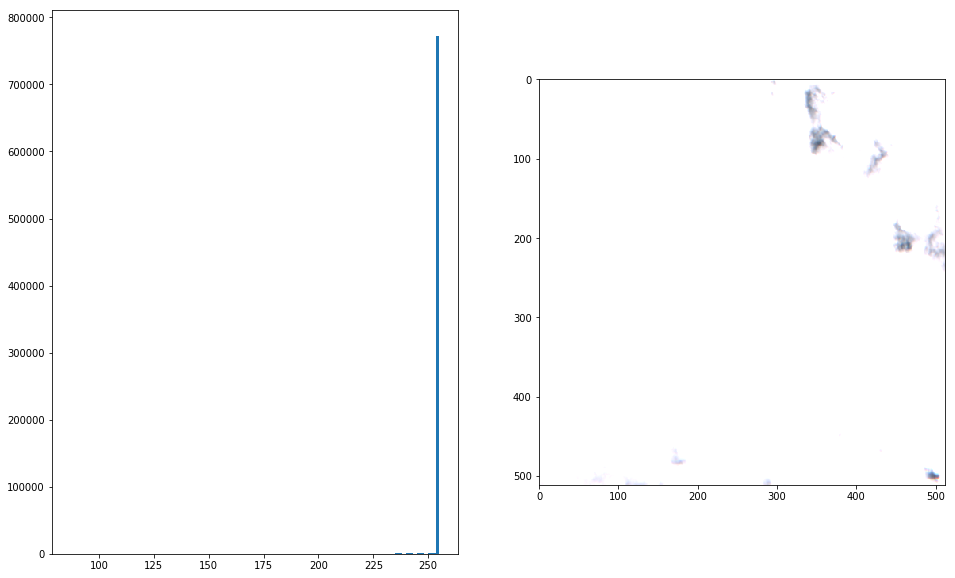

In [64]:
plot(EDA_DATA_ROOT / 'timeseries/7680-10240-TCI-2019-05-21.png')

0.22533035278320312


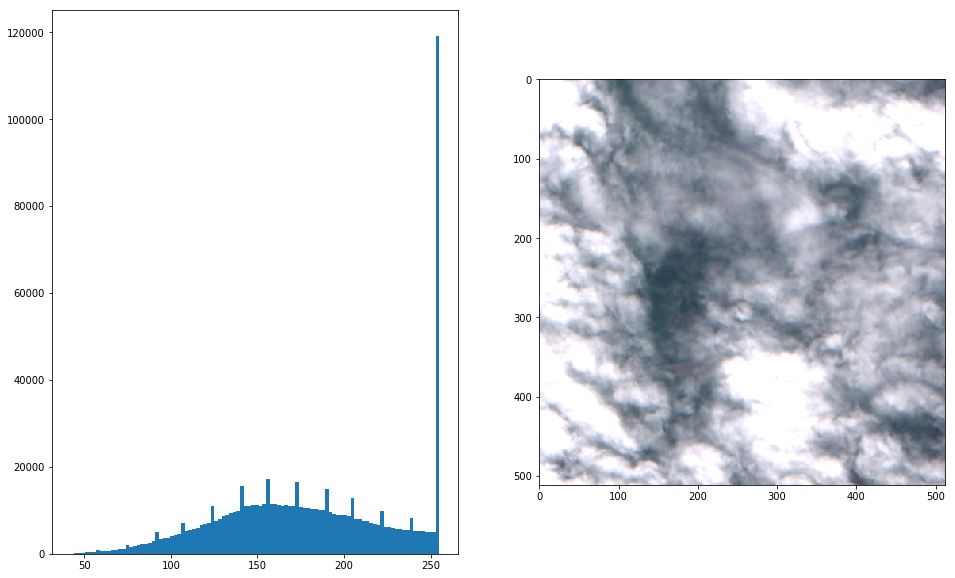

In [65]:
plot(EDA_DATA_ROOT/ 'timeseries/7680-10240-TCI-2019-06-10.png')

0.03231684366861979


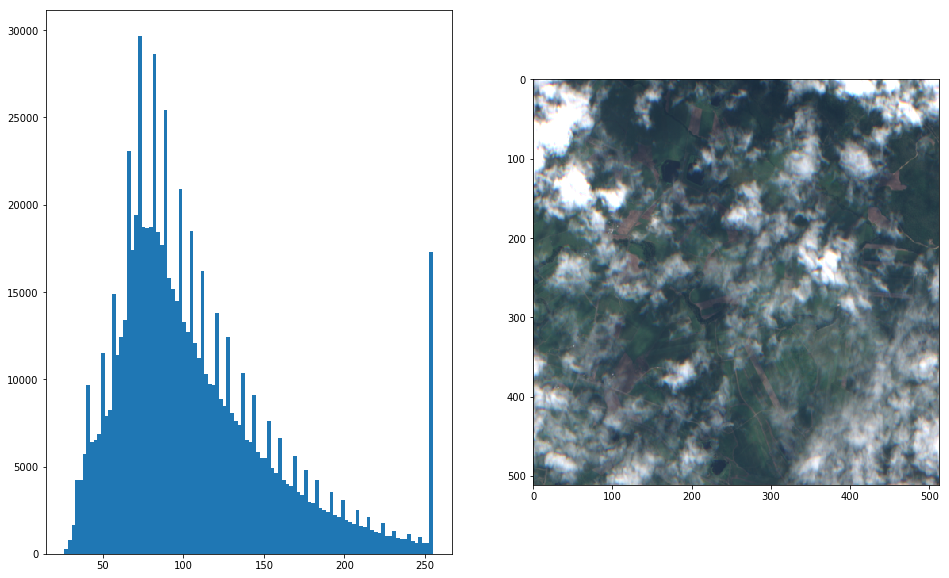

In [66]:
plot(EDA_DATA_ROOT/ 'timeseries/7680-10240-TCI-2019-04-11.png')

0.6441167195638021


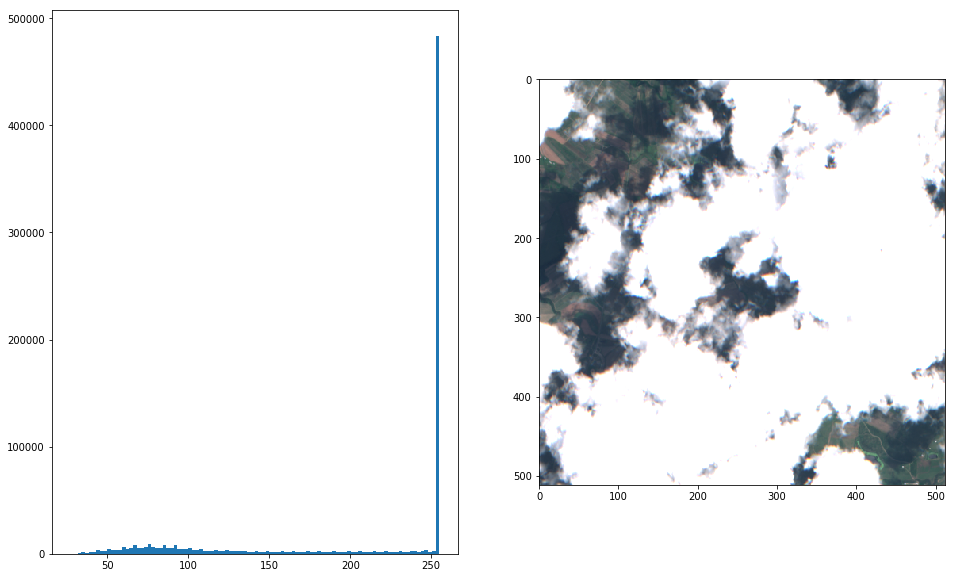

In [67]:
plot(EDA_DATA_ROOT/ 'timeseries/7680-10240-TCI-2017-11-27.png')

# 2. 单tile时间序列EDA

Band 不同，不同物质对光的反射情况不同，其中 B9 B10 云的占比最高。  
TCI 是RGB图像， 便于观察，在此选择TCI band 作为EDA的图像  

In [11]:
eda_imags = file_info.query('SENSING_BAND == "TCI"')

# _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
means =[]
for row in eda_imags.itertuples():
    means.append(np.array(Image.open(row.IMG_FILE)).mean())

eda_imags = eda_imags.assign(
    MEAN=means,
    DATE_DT=pd.to_datetime(eda_imags.DATE_DT)
)

In [12]:
eda_imags = eda_imags.set_index('DATE_DT').merge(metadata['cloud-cover'], how='left', left_index=True, right_index=True)

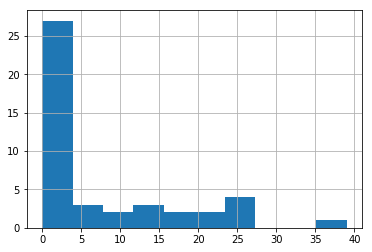

In [13]:
eda_imags['cloud-cover'].hist()

In [14]:
eda_imags[eda_imags['cloud-cover'] >45]

,IMG_FILE,SENSING_BAND,MEAN,cloud-cover
DATE_DT,,,,


In [15]:
eda_imags[['MEAN', 'cloud-cover']].corr()

,MEAN,cloud-cover
MEAN,1.000000,0.215983
cloud-cover,0.215983,1.000000


图像灰度值与云彩密度相关度非常高，因此需要去除云彩后进行判断

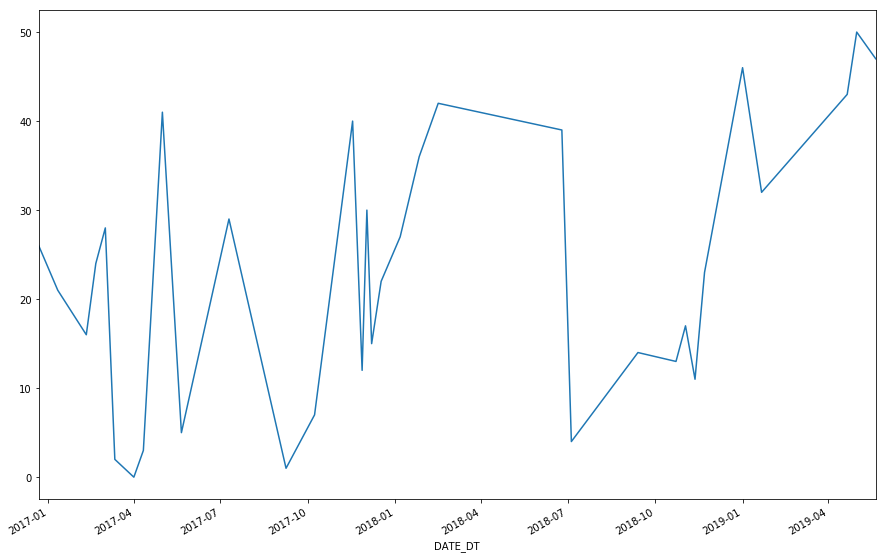

In [16]:
 _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
metadata['cloud-cover'].drop_duplicates().plot(ax=ax)

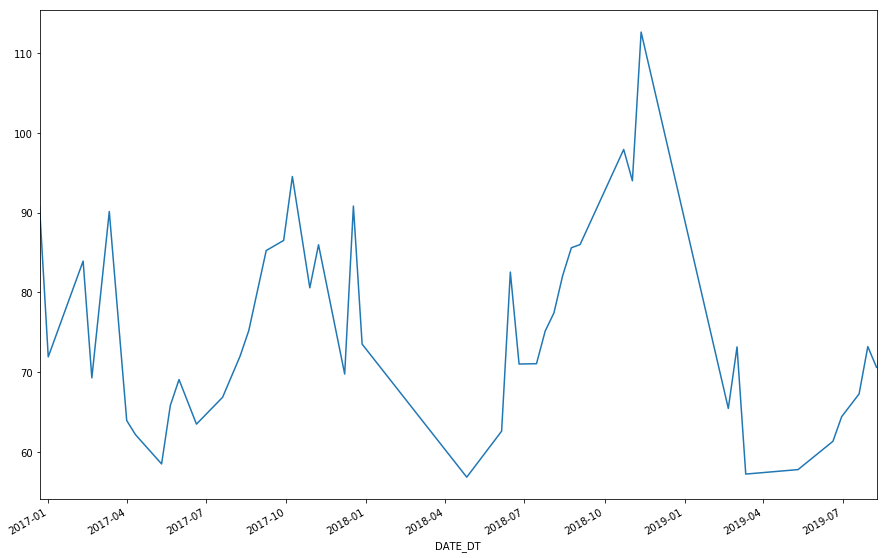

In [17]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
eda_imags['MEAN'].plot()

样例图像，2017-05为成熟，2017-11 为全部收割  
能否根据固定网格，判断当前区域有多少被收割？

In [21]:
eda_imags.IMG_FILE.head()

DATE_DT
2016-12-22    /Users/kevindu/Documents/workspace/ai/geo/mel-...
2017-01-01    /Users/kevindu/Documents/workspace/ai/geo/mel-...
2017-02-10    /Users/kevindu/Documents/workspace/ai/geo/mel-...
2017-02-20    /Users/kevindu/Documents/workspace/ai/geo/mel-...
2017-03-12    /Users/kevindu/Documents/workspace/ai/geo/mel-...
Name: IMG_FILE, dtype: object

In [44]:
img = np.array(Image.open(datadir / 'eda_data'/ '7680-10240-TCI-2018-08-24.png')) 

In [34]:
mask = (np.array(Image.open(datadir / 'masks' /'sugarcane-region-mask.png'))[:, :, -1] > 0).astype('int')

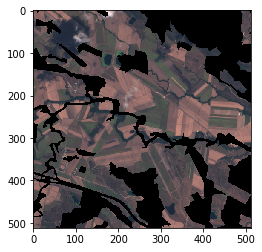

In [46]:
plt.imshow(img * mask[..., None])

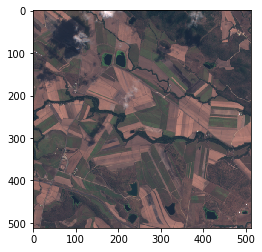

In [45]:
plt.imshow(img)